# Obligatorio - Taller Agentes Inteligentes 2023

Vamos a usar el juego Super Mario Bros:
PyPi: https://pypi.org/project/gym-super-mario-bros/ 
Repo: https://github.com/Kautenja/gym-super-mario-bros

En este caso, el juego está programado como un ambiente de OpenAI Gym, cumpliendo con las interfaces que hemos trabajado en el curso.


El objetivo del juego consta de lograr que nuestro personaje llegue al final de la pantalla, sin ser comido por enemigos o caer al vacío.

![](./assets/images/mario.gif)

Si bien el juego podría considerarse de múltiples agentes (mario, y sus enemigos), utilizaremos unicamente las heramientas del curso para solucionarlo, esto es, todo lo que no conforma a nuestros agentes será considerado ambiente y tratado como tal.

El objetivo es resolver el juego utilizando Deep Q Learning y Double Deep Q Learning, comparando sus resultados.


## Tareas:


1. Completar el código faltante en este notebook (y archivos asociados).


2. Entrenar un agente de Deep Q Learning (DQN) para cada ambiente tal que éste sea capaz de resolverlo.


3. Entrenar un agente de Double Deep Q Learning (DDQN) para cada ambiente tal que éste sea capaz de resolverlo.


4. Graficar las recompensas obtenidas para cada ambiente por cada agente (Ambos agentes resolviendo el ambiente 1 en una misma gráfica, idem para el ambiente 2). Escribir al menos 2 conclusiones de cada grafica. 


5. Grabar un video de cada agente resolviendo cada problema (pueden descargar el video desde colab y entregarlos dentro de un zip).


Recuerden que pueden usar la GPU en google colab para agilizar el entrenamiento. 
***


Fecha de entrega: **04/07** 21hs por gestión (gestion.ort.edu.uy). Pueden trabajar en grupos de hasta 3 estudiantes. 
***

Instalación de librerías. Se fija la versión de gym, dado que para dicha versión las ROMS de los juegos ya estan includias y se evita su instalación separada lo que puede originar problemas.

In [1]:
#%%capture
#!pip install pyvirtualdisplay > /dev/null 2>&1
#!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
#!pip install opencv-python
#!pip install torchsummary
#!pip install nes-py
#!pip install --force-reinstall gym-super-mario-bros==7.4.0  > /dev/null 2>&1
#!pip install --force-reinstall gym==0.15.3 > /dev/null 2>&1
#!pip install pillow==8.4.0
#!pip install torchvision==0.11.1
#!pip install pyglet==1.4.9
#!pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Imports y configuraciones de ambiente

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

import math
import random
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import mario_utils
from replay_memory import ReplayMemory
from abstract_agent import Agent
import gym
from dqn_cnn_model import DQN_CNN_Model
import warnings
warnings.filterwarnings("ignore")

Checkeo de devices

In [3]:
torch.zeros(1).cuda()

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Running on {DEVICE}")

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

print("Cuda Available:", torch.cuda.is_available(), '====>',
torch.cuda.get_device_name(torch.cuda.current_device()))

Running on cuda:0
Cuda Available: True ====> NVIDIA GeForce RTX 4060 Laptop GPU


Setting de seeds

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

Validacion del ambiente

In [5]:
ENV_NAME = "SuperMarioBros-1-1-v0"

env = mario_utils.make_env(ENV_NAME)
print("Actions #",env.action_space.n)
print(env.unwrapped.get_action_meanings())
print(env.observation_space.shape)
env.reset()
next_state, reward, done, info = env.step(action=0)

print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

Actions # 2
['NOOP']
(4, 84, 84)
(4, 84, 84),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


In [6]:
next_state, reward, done, info = env.step(action=0)
torch.Tensor(next_state[:])

tensor([[[0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         ...,
         [0.4862, 0.4862, 0.4862,  ..., 0.4862, 0.5114, 0.4862],
         [0.7494, 0.3820, 0.3579,  ..., 0.2038, 0.4862, 0.4862],
         [0.4515, 0.4515, 0.1305,  ..., 0.7431, 0.4515, 0.0107]],

        [[0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         ...,
         [0.4862, 0.4862, 0.4862,  ..., 0.4862, 0.5114, 0.4862],
         [0.7494, 0.3820, 0.3579,  ..., 0.2038, 0.4862, 0.4862],
         [0.4515, 0.4515, 0.1305,  ..., 0.7431, 0.4515, 0.0107]],

        [[0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.5476],
         [0.5476, 0.5476, 0.5476,  ..., 0.5476, 0.5476, 0.

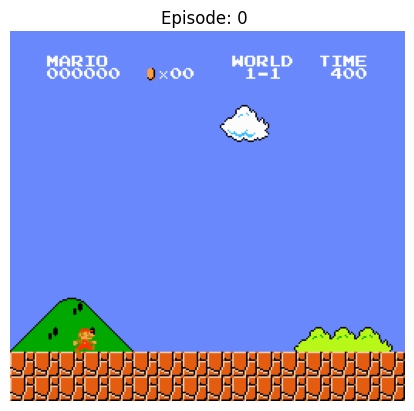

In [7]:
mario_utils.show_state(env)

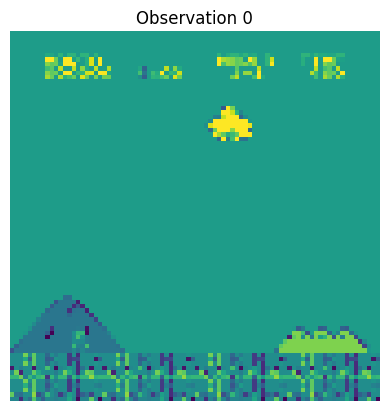

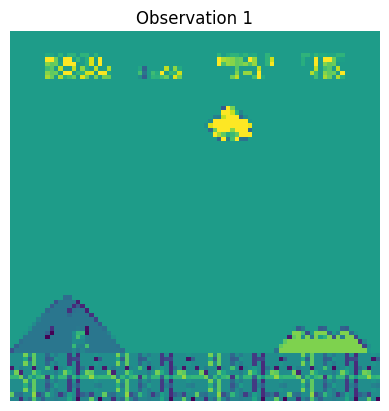

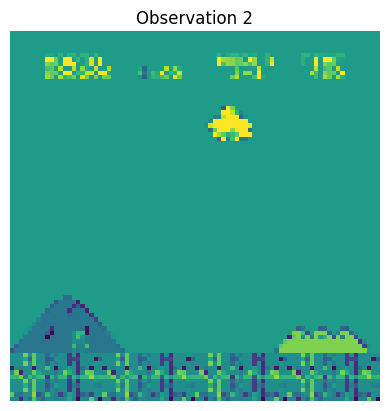

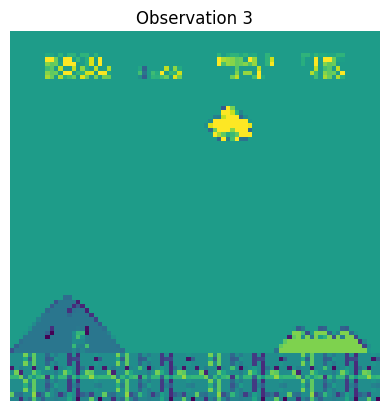

In [8]:
obs = env.reset()
mario_utils.show_obs(obs)

In [9]:
from IPython.display import HTML
from pyvirtualdisplay import Display

#display = Display(visible=0, size=(1400, 900),color_depth=16)
#display.start()

wrapped_env = mario_utils.wrap_env(env)
state = wrapped_env.reset()

while True:        
  #wrapped_env.render()
  state, reward, done, info = wrapped_env.step(wrapped_env.action_space.sample())
  if done:
    break

wrapped_env.close()

In [10]:
mario_utils.show_video()

# Deep Q Learning


Recomendamos empezar implementando Deep Q Learning (paper presentado por DeepMind, pueden encontrar el mismo en arxiv: https://arxiv.org/pdf/1312.5602.pdf0).

***

En las celdas siguientes dejamos el código que deben implementar asi como una explicación del mismo.

# Memoria

El algoritmo de Deep Q Learning presentado en el paper utiliza una memoria (llamada Replay Memory) para almacenar transiciones pasadas. Tuplas que contienen un estado base, la accion tomada, la recompensa obtenida, una bandera que indica si el siguiente estado es final o no; y el estado siguiente.

Esta memoria es circular, es decir, tiene un límite maximo de elementos y una vez esté llena comienza a reemplazar los elementos más viejos.

Vamos a necesitar crear una función **sample** que obtiene una mustra aleatoria de elementos de la memoria.  Esto puede ser una lista de Transiciones o listas separadas (pero alineadas) de los elementos que las componen.

***

Para implementar esta funcionalidad se debe modificar el archivo **replay_memory.py**


In [16]:
from replay_memory import ReplayMemory
buffer_size = 100
memory = ReplayMemory(buffer_size)

def process_state(obs):
    return torch.from_numpy(np.array(obs)).unsqueeze(0)

# Modelo

Vamos a usar un mismo modelo FeedForward para estos dos problemas (entrenado en cada problema particular). Recomendamos simplicidad en la creación del mismo, pero tienen total libertad al momento de implementarlo.

***
Para implementar esta funcionalidad se debe modificar el archivo **dqn_cnn_model.py**


In [12]:
from dqn_cnn_model import DQN_CNN_Model
from mario_utils import make_env

test_env = make_env(ENV_NAME)

input_channels = test_env.observation_space.shape[0]
test_net = DQN_CNN_Model(input_channels, test_env.action_space.n).to(DEVICE)

from torchsummary import summary
summary(test_net, test_env.observation_space.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 20, 20]           4,112
              ReLU-2           [-1, 16, 20, 20]               0
            Conv2d-3             [-1, 32, 9, 9]           8,224
              ReLU-4             [-1, 32, 9, 9]               0
            Linear-5                  [-1, 256]         663,808
            Linear-6                    [-1, 2]             514
Total params: 676,658
Trainable params: 676,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.14
Params size (MB): 2.58
Estimated Total Size (MB): 2.83
----------------------------------------------------------------


# Agente

Vamos a definir una clase agente, encargado de interactuar con el ambiente y entrenar los modelos. Los métdos definidos deben funcionar para ambos problemas simplemente cambiando el modelo a utilizar para cada ambiente.

Abajo dejamos un esqueleto del mismo y las funciones a completar. Recomendamos no alterar la estructura del mismo, pero pueden definir las funciones auxiliares que consideren necesarias.

Una aclaracion particular es sobre los últimos tres parametros del agente, representan los valores de epsilon_inicial, epsilon_final y el tiempo (numero de steps) que tardamos en llegar del epsilon final al inicial (puede decrementarlo de forma lineal o exponencial en el número de steps).

***

Para implementar esta funcionalidad se debe modificar los archivos **abstract_agent.py**, **dqn_agent.py** y **double_dqn_agent.py**.

Funciones a completar:


1. init: que inicializa los parametros del agente.

2. compute_epsilon: que computa el valor actual de epsilon en base al número de pasos actuales.

3. select_action: Seleccionando acciones "epsilongreedy-mente" si estamos entranando y completamente greedy en otro caso.

4. train: que entrena el agente por un número dado de episodios de largo determinado.

5. record_test_episode: para grabar un episodio con el agente siempre seleccionando la mejor accion conocida.

# Entrenamiento

Para entrenar van a necesitar definir:

1. El ambiente.
2. Una instancia del modelo a utilizar para el problema (ej: `mario_model = DQNModel(espacio_obs, num_acciones)`.
3. La función para procesar los estados (phi en el paper) que es necesaria para poder usar el modelo de Pytorch con las representaciones de gym.

Una vez definido pueden llamar a la función train del agente para entrenarlo y problar las demás funciones.

***

Una de las cosas que recomendamos hacer para probar los algoritmos es entrenar el agente por una cantidad X de episodios, grabar un video para observar progreso, volver a entrenar el mismo agente y volver a grabar un video, todas las veces que considere necesario.

***

In [13]:
%load_ext tensorboard

In [14]:
#Hiperparámetros de entrenamiento del agente DQN
TOTAL_STEPS =1000000
EPISODES = 50
STEPS = 100000

EPSILON_INI = 1
EPSILON_MIN = 0.02
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = max(1, int(EPISODES * 0.9))
EPISODE_BLOCK = 20

BATCH_SIZE = 128
BUFFER_SIZE = 30000

GAMMA = 0.99
LEARNING_RATE = 1e-4

In [15]:
from dqn_agent import DQNAgent
env = mario_utils.make_env(ENV_NAME)

# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

net = DQN_CNN_Model(test_env.observation_space.shape[0], 2).to(DEVICE)

ruta_archivo = "/mnt/c/Users/crisd/OneDrive/Escritorio/python/mario/letra/obligatorio/modelo_pesos.pth"
net.load_state_dict(torch.load(ruta_archivo))

#gym_env, model, obs_processing_func, memory_buffer_size, batch_size, learning_rate, gamma, epsilon_i, epsilon_f, epsilon_anneal_time
agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME, epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK)

rewards = agent.train(EPISODES, STEPS, TOTAL_STEPS, writer_name = ENV_NAME)

torch.save(net.state_dict(), ruta_archivo,)

  0%|          | 0/50 [00:01<?, ? episodes/s]


RuntimeError: Given groups=1, weight of size [16, 4, 8, 8], expected input[1, 512, 84, 84] to have 4 channels, but got 512 channels instead

# Videos

Para grabar los videos hacemos uso de la funcion `record_test_episode`  definida en nuestro agente.

Dejamos un ejemplo de como hacerlo:

In [ ]:
#initial environment
env = mario_utils.make_env(ENV_NAME)
wrapped_env = mario_utils.wrap_env(env)
agent.record_test_episode(wrapped_env)

# Double Deep Q Learning

Una variante del clásico algoritmo Q Learning, es Double Q Learning, este surge como solución al problema de sesgo de maximización. Esta variante fue rápidamente adaptada con tecnicás de optimización por decenso de gradientes (https://arxiv.org/pdf/1509.06461.pdf). Recomendamos leer el algoritmo del libro de Sutton y Barto para maximizar su entendimiento del mismo.

***

Vamos a utilizar el mismo modelo de red neuronal creado para el problema anterior y la misma implementación de memoria, dejamos un esqueleto de un agente de Double Deep Q learning para completar en el archivo **double_dqn_agent.py**

In [ ]:
#Hiperparámetros de entrenamiento del agente Doble DQN

TOTAL_STEPS =100000000
EPISODES = 50
STEPS = 1000000

EPSILON_INI = 1
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = EPISODES
EPISODE_BLOCK = 10

BATCH_SIZE = 128
BUFFER_SIZE = 40000

GAMMA = 0.99
LEARNING_RATE = 1e-4


In [ ]:
env = mario_utils.make_env(ENV_NAME)
from double_dqn_agent import DoubleDQNAgent
# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

modelo_a = DQN_CNN_Model(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
modelo_b = DQN_CNN_Model(env.observation_space.shape[0], env.action_space.n).to(DEVICE)

ruta_archivo_a = "/mnt/c/Users/crisd/OneDrive/Escritorio/python/mario/letra/obligatorio/modelo_pesos_dobleqa.pth"
modelo_a.load_state_dict(torch.load(ruta_archivo_a))

ruta_archivo_b = "/mnt/c/Users/crisd/OneDrive/Escritorio/python/mario/letra/obligatorio/modelo_pesos_dobleqb.pth"
modelo_b.load_state_dict(torch.load(ruta_archivo_b))

agent = DoubleDQNAgent(env, modelo_a, modelo_b, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME, epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK)

rewards = agent.train(EPISODES, STEPS, TOTAL_STEPS)
torch.save(agent.modelo_a.state_dict(), ruta_archivo_a)
torch.save(agent.modelo_b.state_dict(), ruta_archivo_b)

In [ ]:
#initial environment
env = mario_utils.make_env(ENV_NAME)
wrapped_env = mario_utils.wrap_env(env)
agent.record_test_episode(wrapped_env)

# Variacion de libro

Esto lo encontramos en un libro (lo hicimos adicional, para ver como varia)

In [ ]:
#Hiperparámetros de entrenamiento del agente Doble DQN

TOTAL_STEPS =100000000
EPISODES = 50
STEPS = 1000000

EPSILON_INI = 1
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.99998599985
EPSILON_TIME = EPISODES
EPISODE_BLOCK = 10

BATCH_SIZE = 64
BUFFER_SIZE = 40000

GAMMA = 0.99
LEARNING_RATE = 1e-4

In [ ]:
env = mario_utils.make_env(ENV_NAME)
from agente_dobleq import libro
# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

modelo_libro = DQN_CNN_Model(env.observation_space.shape[0], env.action_space.n).to(DEVICE)

ruta_archivo_libro = "/mnt/c/Users/crisd/OneDrive/Escritorio/python/mario/letra/obligatorio/modelo_pesos_dobleq_libro.pth"
modelo_libro.load_state_dict(torch.load(ruta_archivo_libro))

agent = libro(env, modelo_libro, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME, epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK)

rewards = agent.train(EPISODES, STEPS, TOTAL_STEPS)
torch.save(agent.modelo_a.state_dict(), ruta_archivo_libro)

In [ ]:
#initial environment
env = mario_utils.make_env(ENV_NAME)
wrapped_env = mario_utils.wrap_env(env)
agent.record_test_episode(wrapped_env)


# Comparaciones, Resultados, Comentarios...
De aquí en adelante son libres de presentar como gusten los resultados comparativos de las técnicas.